# Association/dissociation kinetics

In [1]:
%load_ext slurm_magic

In [4]:
%%sbatch
#!/bin/bash
#SBATCH --job-name=kinetic
#SBATCH --output=simulations/kinetic%a_%A.out
#SBATCH --gres=gpu:1   # Request 1 GPU
#SBATCH --array=0-11

kon=(0.01 0.01 0.01 0.01 0.02 0.02 0.02 0.02 0.03 0.03 0.03 0.03)
lamda=(0.01 0.15 0.5 1 0.01 0.15 0.5 1 0.01 0.15 0.5 1 0.01 0.15 0.5 1)

# Path to your executable
python ../examples/kinetic_simulations.py \
  -N 100 -F 1000 -bs 16 --cuda --dtype double \
  --kon ${kon[${SLURM_ARRAY_TASK_ID}]} \
  --lamda ${lamda[${SLURM_ARRAY_TASK_ID}]} \
  --path simulations/kon${kon[${SLURM_ARRAY_TASK_ID}]}lamda${lamda[${SLURM_ARRAY_TASK_ID}]}

'Submitted batch job 1895\n'

In [5]:
%squeue

,JOBID,PARTITION,NAME,USER,ST,TIME,NODES,NODELIST(REASON)
0,1895_[2-11],theobald-,kinetic,ordabaye,PD,0:00,1,(Resources)
1,1895_0,theobald-,kinetic,ordabaye,R,0:01,1,centaur
2,1895_1,theobald-,kinetic,ordabaye,R,0:01,1,centaur


In [1]:
import numpy as np
import pandas as pd
from pyroapi import handlers, infer, pyro, pyro_backend
from pyro import distributions as dist
from pyro.ops.stats import pi
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path

from tapqir.models import Cosmos
from tapqir.utils.imscroll import association_rate, dissociation_rate

## Load results

In [2]:
# path to simulated data
SIMULATIONS_DIR = Path("simulations")

In [4]:
model.statistics

,Mean,95% LL,95% UL
gain,7.100768899757334,7.097723,7.103717
proximity,0.22307867893854588,0.219865,0.225997
lamda,0.9605101748297807,0.955898,0.964383
pi,0.07661475153698845,0.074828,0.078410
Keq,0.082935018578909,0.080880,0.085081
SNR,3.84891868091762,NaN,NaN
MCC,0.9016014291771309,NaN,NaN
Recall,0.8914011246485474,NaN,NaN
Precision,0.9286062972907005,NaN,NaN
TN,90879,NaN,NaN


In [14]:
truth = {}
fit = {}

for data_path in SIMULATIONS_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("kon"):
        # load results
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        
        model = Cosmos(verbose=False)
        model.load(data_path, data_only=False)
        
        fit[data_path.name] = model.statistics.drop("trained").astype(float)
        #fit[data_path.name]["kon"] = truth[data_path.name]["kon"]
        #fit[data_path.name]["lamda"] = truth[data_path.name]["lamda"]
        for p in ("gain", "proximity", "lamda", "SNR", "kon", "koff"):
            fit[data_path.name].loc[p, "True"] = truth[data_path.name][p]       

        z_samples = dist.Bernoulli(model.params["p(specific)"]).sample((500,))
        # kon distribtion (MLE fit)
        kon_samples = association_rate(z_samples)
        fit[data_path.name].loc["kon", "Mean"] = kon_samples.mean().item()
        hdp = pi(kon_samples, 0.95, dim=0)
        fit[data_path.name].loc["kon", "95% LL"] = hdp[0].item()
        fit[data_path.name].loc["kon", "95% UL"] = hdp[1].item()
        # koff distribution (MLE fit)
        koff_samples = dissociation_rate(z_samples)
        hdp = pi(koff_samples, 0.95, dim=0)
        fit[data_path.name].loc["koff", "Mean"] = koff_samples.mean().item()
        fit[data_path.name].loc["koff", "95% LL"] = hdp[0].item()
        fit[data_path.name].loc["koff", "95% UL"] = hdp[1].item()

In [12]:
truth_df = pd.concat(truth.values(), axis=1).T.astype(float)
truth_df["Keq"] = truth_df["kon"] / truth_df["koff"]
truth_df = truth_df.sort_values(by=["kon", "lamda"])
truth_df

,width,gain,kon,koff,lamda,proximity,offset,height,background,SNR,N,F,Nc,Fc,P,Keq
kon0.01lamda0.01,1.4,7.0,0.01,0.2,0.01,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.05
kon0.01lamda0.15,1.4,7.0,0.01,0.2,0.15,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.05
kon0.01lamda0.5,1.4,7.0,0.01,0.2,0.50,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.05
kon0.01lamda1,1.4,7.0,0.01,0.2,1.00,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.05
kon0.02lamda0.01,1.4,7.0,0.02,0.2,0.01,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.10
kon0.02lamda0.15,1.4,7.0,0.02,0.2,0.15,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.10
kon0.02lamda0.5,1.4,7.0,0.02,0.2,0.50,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.10
kon0.02lamda1,1.4,7.0,0.02,0.2,1.00,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.10
kon0.03lamda0.01,1.4,7.0,0.03,0.2,0.01,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.15
kon0.03lamda0.15,1.4,7.0,0.03,0.2,0.15,0.2,90.0,3000.0,150.0,3.758899,100.0,1000.0,100.0,1000.0,14.0,0.15


In [13]:
description = pd.Series(dtype=str, name="Description")
description["N"] = "Number of on-target AOIs"
description["F"] = "Number of frames for on-target AOIs"
description["Nc"] = "Number of control off-target AOIs"
description["Fc"] = "Number of frames for off-target AOIs"
description["P"] = "Number of pixels along x- and y-axes of an AOI"
description["height"] = "Spot intensity"
description["width"] = "Spot width"
description["snr"] = "Signal-to-noise ratio"
description["background"] = "Image background"
description["pi"] = "Average target-specific binding probability"
description["lamda"] = "Non-specific binding rate"
description["proximity"] = "Proximity parameter"
description["p(specific)"] = "Probability of there being any target-specific spot in an AOI image"
description["_ul"] = "95% CI upper-limit"
description["_ll"] = "95% CI lower-limit"
description["MCC"] = "Matthews correlation coefficient"
description["TP"] = "True positives"
description["FN"] = "False negatives"
description["TN"] = "True negatives"
description["FP"] = "False positives"

## Supplementary Data 5

In [44]:
with pd.ExcelWriter("/home/ordabayev/repos/tapqir-overleaf/supplementary/data5/kinetic.xlsx") as writer:
    truth_df.to_excel(writer, sheet_name="simulation")
    for key, value in fit.items():
        value.to_excel(writer, sheet_name=key)
    description.to_excel(writer, sheet_name="description")

## Figure 6

### Keq

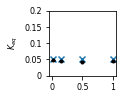

In [29]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
mask = (truth_df["kon"] == 0.01)
plt.scatter(truth_df.loc[mask, "lamda"], truth_df.loc[mask, "Keq"], marker="x")
plt.errorbar(truth_df.loc[mask, "lamda"], [fit[i].loc["Keq", "Mean"] for i in truth_df.index if i.startswith("kon0.01")],
             yerr=torch.tensor([abs(fit[i].loc["Keq", ["95% LL", "95% UL"]].values - fit[i].loc["Keq", "Mean"]) for i in truth_df.index if i.startswith("kon0.01")]).T,
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2, label="fit")
ax.set_ylim(0, 0.2)
ax.set_xlim(-0.05, 1.05)
ax.set_xticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=8)
plt.ylabel(r"$K_{eq}$", fontsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/keq1.svg")
plt.show()

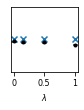

In [30]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
mask = (truth_df["kon"] == 0.02)
plt.scatter(truth_df.loc[mask, "lamda"], truth_df.loc[mask, "Keq"], marker="x")
plt.errorbar(truth_df.loc[mask, "lamda"], [fit[i].loc["Keq", "Mean"] for i in truth_df.index if i.startswith("kon0.02")],
             yerr=torch.tensor([abs(fit[i].loc["Keq", ["95% LL", "95% UL"]].values - fit[i].loc["Keq", "Mean"]) for i in truth_df.index if i.startswith("kon0.02")]).T,
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2, label="fit")
ax.set_ylim(0, 0.2)
ax.set_xlim(-0.05, 1.05)
ax.set_yticks([])
ax.set_xticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=8)
ax.set_xlabel(r"$\lambda$", fontsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/keq2.svg")
plt.show()

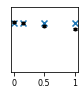

In [31]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
mask = (truth_df["kon"] == 0.03)
plt.scatter(truth_df.loc[mask, "lamda"], truth_df.loc[mask, "Keq"], marker="x")
plt.errorbar(truth_df.loc[mask, "lamda"], [fit[i].loc["Keq", "Mean"] for i in truth_df.index if i.startswith("kon0.03")],
             yerr=torch.tensor([abs(fit[i].loc["Keq", ["95% LL", "95% UL"]].values - fit[i].loc["Keq", "Mean"]) for i in truth_df.index if i.startswith("kon0.03")]).T,
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2, label="fit")
ax.set_ylim(0, 0.2)
ax.set_xlim(-0.05, 1.05)
ax.set_yticks([])
ax.set_xticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/keq3.svg")
plt.show()

### kon

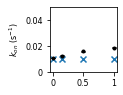

In [19]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
mask = (truth_df["kon"] == 0.01)
plt.scatter(truth_df.loc[mask, "lamda"], truth_df.loc[mask, "kon"], marker="x", label="simulation")
plt.errorbar(truth_df.loc[mask, "lamda"], [fit[i].loc["kon", "Mean"] for i in truth_df.index if i.startswith("kon0.01")],
             yerr=torch.tensor([abs(fit[i].loc["kon", ["95% LL", "95% UL"]].values - fit[i].loc["kon", "Mean"]) for i in truth_df.index if i.startswith("kon0.01")]).T,
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2, label="fit")
ax.set_ylim(0, 0.05)
ax.set_xlim(-0.05, 1.05)
# ax.set_yticks([])
ax.set_xticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.set_ylabel(r"$k_{on}$ (s$^{-1}$)", fontsize=8)
# plt.legend(fontsize=8)
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/kon1.svg")
plt.show()

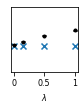

In [20]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
mask = (truth_df["kon"] == 0.02)
plt.scatter(truth_df.loc[mask, "lamda"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "lamda"], [fit[i].loc["kon", "Mean"] for i in truth_df.index if i.startswith("kon0.02")],
             yerr=torch.tensor([abs(fit[i].loc["kon", ["95% LL", "95% UL"]].values - fit[i].loc["kon", "Mean"]) for i in truth_df.index if i.startswith("kon0.02")]).T,
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2, label="fit")
ax.set_ylim(0, 0.05)
ax.set_xlim(-0.05, 1.05)
ax.set_yticks([])
ax.set_xticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.set_xlabel(r"$\lambda$", fontsize=8)
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/kon2.svg")
plt.show()

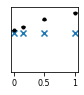

In [21]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
mask = (truth_df["kon"] == 0.03)
plt.scatter(truth_df.loc[mask, "lamda"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "lamda"], [fit[i].loc["kon", "Mean"] for i in truth_df.index if i.startswith("kon0.03")],
             yerr=torch.tensor([abs(fit[i].loc["kon", ["95% LL", "95% UL"]].values - fit[i].loc["kon", "Mean"]) for i in truth_df.index if i.startswith("kon0.03")]).T,
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2, label="fit")
ax.set_ylim(0, 0.05)
ax.set_xlim(-0.05, 1.05)
ax.set_yticks([])
ax.set_xticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/kon3.svg")
plt.show()

### koff

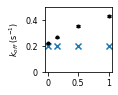

In [24]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
mask = (truth_df["kon"] == 0.01)
plt.scatter(truth_df.loc[mask, "lamda"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "lamda"], [fit[i].loc["koff", "Mean"] for i in truth_df.index if i.startswith("kon0.01")],
             yerr=torch.tensor([abs(fit[i].loc["koff", ["95% LL", "95% UL"]].values - fit[i].loc["koff", "Mean"]) for i in truth_df.index if i.startswith("kon0.01")]).T,
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2, label="fit")
ax.set_ylim(0, 0.5)
ax.set_xlim(-0.05, 1.05)
ax.set_xticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.set_ylabel(r"$k_{off}$ (s$^{-1}$)", fontsize=8)
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/koff1.svg")
plt.show()

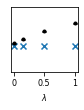

In [25]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
mask = (truth_df["kon"] == 0.02)
plt.scatter(truth_df.loc[mask, "lamda"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "lamda"], [fit[i].loc["koff", "Mean"] for i in truth_df.index if i.startswith("kon0.02")],
             yerr=torch.tensor([abs(fit[i].loc["koff", ["95% LL", "95% UL"]].values - fit[i].loc["koff", "Mean"]) for i in truth_df.index if i.startswith("kon0.02")]).T,
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2, label="fit")
ax.set_ylim(0, 0.5)
ax.set_xlim(-0.05, 1.05)
ax.set_yticks([])
ax.set_xticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.set_xlabel(r"$\lambda$", fontsize=8)
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/koff2.svg")
plt.show()

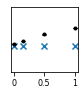

In [27]:
fig, ax = plt.subplots(figsize=(1.2, 1.2))
mask = (truth_df["kon"] == 0.03)
plt.scatter(truth_df.loc[mask, "lamda"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "lamda"], [fit[i].loc["koff", "Mean"] for i in truth_df.index if i.startswith("kon0.03")],
             yerr=torch.tensor([abs(fit[i].loc["koff", ["95% LL", "95% UL"]].values - fit[i].loc["koff", "Mean"]) for i in truth_df.index if i.startswith("kon0.03")]).T,
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2, label="fit")
ax.set_ylim(0, 0.5)
ax.set_xlim(-0.05, 1.05)
ax.set_yticks([])
ax.set_xticks([0, 0.5, 1])
ax.tick_params(axis="both", labelsize=8)
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/koff3.svg")
plt.show()

### Traces

In [34]:
model = Cosmos(verbose=False)
model.load(SIMULATIONS_DIR / "kon0.02lamda1", data_only=False)
z_samples = dist.Bernoulli(model.params["p(specific)"]).sample((500,))

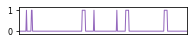

In [40]:
plt.figure(figsize=(3, 0.5))

n = 4
f1 = 0
f2 = 300
plt.plot(
    torch.arange(f1, f2),
    model.data.ontarget.labels["z"][n, f1:f2],
    "-", lw=1, color="C4", label="simulation")

plt.xticks([], fontsize=8)
plt.yticks([0, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/simulation.svg")
plt.show()

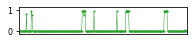

In [41]:
plt.figure(figsize=(3, 0.5))

plt.plot(
    torch.arange(f1, f2),
    model.params["p(specific)"][n, f1:f2],
    "o-", ms=1, lw=0.5, color="C2", label="fit")

plt.xticks([], fontsize=8)
plt.yticks([0, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/pspecific.svg")
plt.show()

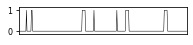

In [42]:
plt.figure(figsize=(3, 0.5))

plt.plot(
    torch.arange(f1, f2),
    z_samples[5, n, f1:f2],
    "-", ms=2, lw=0.5, color="k", label="fit")

plt.xticks([], fontsize=8)
plt.yticks([0, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/sample1.svg")
plt.show()

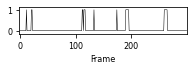

In [43]:
plt.figure(figsize=(3, 0.5))

plt.plot(
    torch.arange(f1, f2),
    z_samples[1, n, f1:f2],
    "-", ms=2, lw=0.5, color="k", label="fit")

plt.xticks(fontsize=8)
plt.yticks([0, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
plt.xlabel("Frame", fontsize=8)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))

plt.savefig("/home/ordabayev/repos/tapqir-overleaf/figures/figure6/sample2.svg")
plt.show()